## DATA PREPROCESSING AND FEATURE ENGINEERING

In [1]:
import gc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle 

pd.set_option("display.max_columns" , None)
pd.set_option("display.float_format", lambda x : "%.4f" %x)
pd.set_option("display.width", 200)

In [2]:
def reduce_mem_usage2(df):
   
    """ 
        iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def one_hot_encoder(dataframe,dummy_na = True):
    
    cols = [col for col in dataframe.columns]
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == "object"]
    dataframe = pd.get_dummies(dataframe, columns= cat_cols, dummy_na=dummy_na)
    new_cols = [col for col in dataframe.columns if col not in cols]
    return dataframe, new_cols

In [4]:
def summary(data):
    
    columns = [col for col in data.columns]
    dtypes = [data[col].dtypes for col in data.columns.tolist()]
    nunique = [data[col].nunique() for col in data.columns]
    na_values = [data[col].isnull().sum() for col in data.columns]
    na_values_perc = [data[col].isnull().sum() / len(data) for col in data.columns]
    
    dataframe = pd.DataFrame()
    dataframe["NAME"] = columns
    dataframe["DTYPES"] = dtypes
    dataframe["NUNIQUE"] = nunique
    dataframe["NA_VALUES"] = na_values
    dataframe["NA_VALUES_PERC"] = na_values_perc
    dataframe = dataframe.sort_values(by = "NA_VALUES_PERC")
    dataframe = dataframe.set_index("NAME")
    
    return dataframe

In [5]:
def missing_graph(dataframe,num):
    
    nan_data = pd.DataFrame()
    
    na_valeus = [(dataframe[col].isnull().sum() / len(dataframe)) *100 for col in dataframe.columns] 
    names = [col for col in dataframe.columns]
    
    nan_data["NA_VALUES"] = na_valeus
    nan_data["NAME"] = names
    nan_data = nan_data.sort_values(by = "NA_VALUES", ascending = False)[0:num]
    
    plt.figure(figsize = (20,8))
    sns.barplot(x = nan_data["NAME"], y = nan_data["NA_VALUES"])
    plt.xticks(rotation = 90, fontsize = 10)
    plt.tight_layout()
    plt.show()

In [6]:
def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    
    train_path = "/Users/gokhanersoz/Desktop/Home_Credict/home-credit-default-risk/application_train.csv"
    test_path = "/Users/gokhanersoz/Desktop/Home_Credict/home-credit-default-risk/application_test.csv"
    
    train_df = pd.read_csv(train_path, nrows=num_rows)
    test_df = pd.read_csv(test_path, nrows=num_rows)
    
    df = train_df.append(test_df).reset_index()

    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

    # Some simple new features (percentages)
    df['NEW_DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['NEW_INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['NEW_PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    df.columns = pd.Index(["APP_" + col for col in df.columns.tolist()])
    df.rename(columns={"APP_SK_ID_CURR": "SK_ID_CURR"}, inplace=True)
    df.rename(columns={"APP_TARGET": "TARGET"}, inplace=True)

    del test_df
    gc.collect()
    
    pd.to_pickle(df , open("PKL/application_train_test.pkl","wb"))
    
    return df

In [7]:
def bureau_and_balance(num_rows = None, dummy_na = True):
    
    bureau_path = "/Users/gokhanersoz/Desktop/Home_Credict/home-credit-default-risk/bureau.csv"
    bb_path = "/Users/gokhanersoz/Desktop/Home_Credict/home-credit-default-risk/bureau_balance.csv"

    bb = pd.read_csv(bb_path, nrows = num_rows)
    bureau = pd.read_csv(bureau_path, nrows = num_rows)

    bb,bb_cat = one_hot_encoder(bb,dummy_na=dummy_na)
    bureau, bureau_cat = one_hot_encoder(bureau, dummy_na=dummy_na)
    
    bb_aggregations = {"MONTHS_BALANCE" : ["min","max","size"]}
    
    for cat in bb_cat:
        bb_aggregations[cat] = ["mean"]
        
    bb_agg = bb.groupby("SK_ID_BUREAU").agg(bb_aggregations)
    bb_agg.columns = pd.Index([col[0] + "_" + col[1].upper() for col in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how = "left", on = "SK_ID_BUREAU")
    bureau.drop(["SK_ID_BUREAU"], axis = 1, inplace = True)
    
    del bb, bb_agg
    
    gc.collect()
    
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    cat_aggregations = {}
    
    for cat in bureau_cat:
        cat_aggregations[cat] = ["mean"]
        
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ["mean"]
        
    bureau_agg = bureau.groupby("SK_ID_CURR").agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(["BURO_" + col[0] + "_" + col[1].upper()
                                   for col in bureau_agg.columns.tolist()])
    
    # Active
    active = bureau[bureau["CREDIT_ACTIVE_Active"] == 1]
    active_agg = active.groupby("SK_ID_CURR").agg(num_aggregations)
    active_agg.columns = pd.Index(["BURO_NEW_ACTIVE_" + col[0] + "_" + col[1].upper() 
                                   for col in active_agg.columns.tolist()])
    
    bureau_agg = bureau_agg.join(active_agg, how = "left", on = "SK_ID_CURR")
    
    # Close
    closed = bureau[bureau["CREDIT_ACTIVE_Closed"] == 1]
    closed_agg = active.groupby("SK_ID_CURR").agg(num_aggregations)
    closed_agg.columns = pd.Index(["BURO_NEW_CLOSED_" + col[0] + "_" + col[1].upper()
                                  for col in closed_agg.columns.tolist()])
    
    bureau_agg = bureau_agg.join(closed_agg, how = "left", on = "SK_ID_CURR")
    
    del closed, closed_agg, bureau
    gc.collect()
    
    pd.to_pickle(bureau_agg, open("PKL/bureau_agg.pkl","wb"))
    
    return bureau_agg

In [8]:
def previous_applications(num_rows = None, dummy_na = True):
    
    prev_path = "/Users/gokhanersoz/Desktop/Home_Credict/home-credit-default-risk/previous_application.csv"
    
    prev = pd.read_csv(prev_path, nrows= num_rows)
    
    prev, prev_cat = one_hot_encoder(prev, dummy_na= dummy_na)
    
    # days 365.243 values >> nan
    
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    
    # New Feature
    prev["NEW_APP_CREDIT_PERC"] = prev["AMT_APPLICATION"] / prev["AMT_CREDIT"]
    
    # numeric feature !!!
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'NEW_APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    cat_aggregations = {}
    
    for cat in cat_aggregations:
        cat_aggregations[cat] = ["mean"]
        
    prev_agg = prev.groupby("SK_ID_CURR").agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(["PREV_" + col[0] + "_" + col[1].upper() for col in prev_agg.columns.tolist()])
    
    
    # Approved
    approved = prev[prev["NAME_CONTRACT_STATUS_Approved"] == 1]
    approved_agg = approved.groupby("SK_ID_CURR").agg(num_aggregations)
    approved_agg.columns = pd.Index(["PREV_NEW_APPROVED_" + col[0] + "_" + col[1].upper() 
                                     for col in approved_agg.columns.tolist()])
    
    prev_agg = prev_agg.join(approved_agg, how = "left" , on = "SK_ID_CURR")
    
    # Refused
    refused = prev[prev["NAME_CONTRACT_STATUS_Refused"] == 1]
    refused_agg = refused.groupby("SK_ID_CURR").agg(num_aggregations)
    refused_agg.columns = pd.Index(["PREV_NEW_REFUSED_" + col[0] + "_" + col[1].upper() 
                                    for col in refused_agg.columns.tolist()])
    
    prev_agg = prev_agg.join(refused_agg, how = "left", on = "SK_ID_CURR")
    
    del refused, refused_agg, approved, approved_agg ,prev
    gc.collect()
    
    pd.to_pickle(prev_agg, open("PKL/prev_agg.pkl","wb"))
    
    return prev_agg

In [9]:
def pos_cash(num_rows = None, dummy_na = True):
    
    pos_path = "/Users/gokhanersoz/Desktop/Home_Credict/home-credit-default-risk/POS_CASH_balance.csv"
    pos = pd.read_csv(pos_path, nrows=num_rows)
    pos, pos_cat = one_hot_encoder(pos, dummy_na=dummy_na)
    
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    
    for cat in pos_cat:
        aggregations[cat] = ["mean"]
        
    pos_agg = pos.groupby("SK_ID_CURR").agg(aggregations)
    
    pos_agg.columns = pd.Index(["POS_" + col[0] + "_" + col[1].upper() for col in pos_agg.columns.tolist()])
    
    pos_agg["POS_NEW_COUNT"] = pos.groupby("SK_ID_CURR").size()
    
    del pos
    gc.collect()
    
    pd.to_pickle(pos_agg, open("PKL/pos_agg.pkl","wb"))
    
    return pos_agg


In [10]:
def installments_payment(num_rows = None, dummy_na = True):
    
    ins_path = "/Users/gokhanersoz/Desktop/Home_Credict/home-credit-default-risk/installments_payments.csv"
    ins = pd.read_csv(ins_path, nrows= num_rows)
    ins, ins_cat = one_hot_encoder(ins, dummy_na=dummy_na)
    
    
    ins['NEW_PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['NEW_PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['NEW_DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['NEW_DPD'] = ins['NEW_DPD'].apply(lambda x: x if x > 0 else 0)

    ins['NEW_DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['NEW_DBD'] = ins['NEW_DBD'].apply(lambda x: x if x > 0 else 0)
    
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'NEW_DPD': ['max', 'mean', 'sum'],
        'NEW_DBD': ['max', 'mean', 'sum'],
        'NEW_PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'NEW_PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    
    for cat in ins_cat:
        aggregations[cat] = ["mean"]
        
    ins_agg = ins.groupby("SK_ID_CURR").agg(aggregations)
    ins_agg.columns = pd.Index(["INSTAL_" + col[0] + "_" + col[1].upper() 
                                for col in ins_agg.columns.tolist() ])
    
    ins_agg["INSTAL_NEW_COUNT"] = ins.groupby("SK_ID_CURR").size()
    
    del ins
    gc.collect()
    
    pd.to_pickle(ins_agg, open("PKL/ins_agg.pkl","wb"))
    
    return ins_agg

In [11]:
def credit_card_balance(num_rows = None, dummy_na = True):
    
    cc_path = "/Users/gokhanersoz/Desktop/Home_Credict/home-credit-default-risk/credit_card_balance.csv"
    cc = pd.read_csv(cc_path, nrows = num_rows)
    cc, cc_cat = one_hot_encoder(cc, dummy_na=dummy_na)
    
    cc.drop(["SK_ID_PREV"], axis = 1, inplace = True)
    cc_agg = cc.groupby("SK_ID_CURR").agg(["min","max","mean","sum","var"])
    cc_agg.columns = pd.Index(["CC_" + col[0] + "_" + col[1].upper() 
                              for col in cc_agg.columns.tolist()])
    
    cc_agg["CC_NEW_COUNT"] = cc.groupby("SK_ID_CURR").size()
    
    del cc
    gc.collect()
    
    pd.to_pickle(cc_agg, open("PKL/cc_agg.pkl","wb"))
    
    return cc_agg
    

In [12]:
def last_dataframe(num_rows = None):
    
    import re

    df = application_train_test(num_rows)
    
    bureau_agg = bureau_and_balance(num_rows)
    df = df.join(bureau_agg, how = "left", on = "SK_ID_CURR")
    del bureau_agg
    gc.collect()
    
    prev_agg = previous_applications(num_rows)
    df = df.join(prev_agg, how = "left", on = "SK_ID_CURR")
    del prev_agg
    gc.collect()
    
    pos_agg = pos_cash(num_rows)
    df = df.join(pos_agg, how = "left" , on = "SK_ID_CURR")
    del pos_agg
    gc.collect()
    
    ins_agg = installments_payment(num_rows)
    df = df.join(ins_agg, how = "left", on = "SK_ID_CURR")
    del ins_agg
    gc.collect()
    
    cc_agg = credit_card_balance(num_rows)
    df = df.join(cc_agg, how = "left", on = "SK_ID_CURR")
    del cc_agg
    gc.collect()
    
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    for col in df.columns:
        if np.isinf(df[col]).sum() > 0 :
            df[col].replace([np.inf, -np.inf],np.nan,inplace = True)
    
    pd.to_pickle(df, open("PKL/last_dataframe.pkl","wb"))
    
    return df

In [14]:
reduced_df = reduce_mem_usage2(last_dataframe())
pd.to_pickle(reduced_df, open("reduced_dataframe.pkl","wb"))

Memory usage of dataframe is 1423.20 MB
Memory usage after optimization is: 538.50 MB
Decreased by 62.2%


In [16]:
df = last_dataframe()
print("DataFrame Shape : {}".format(df.shape))

DataFrame Shape : (356251, 639)


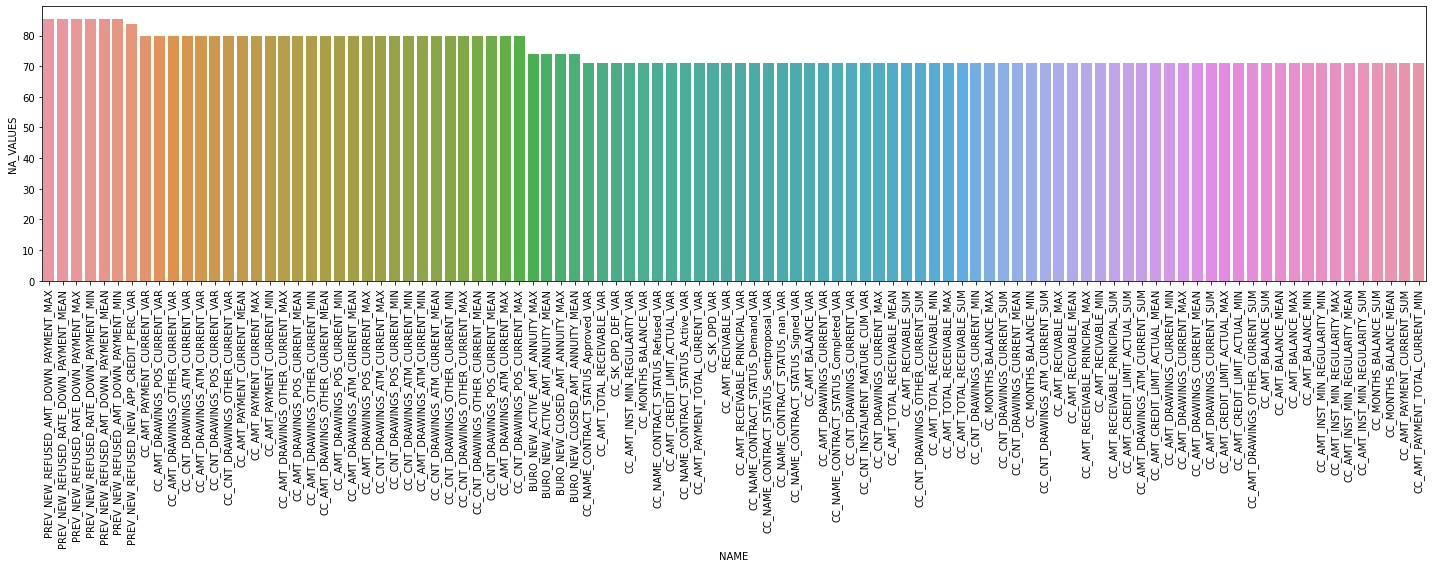

In [17]:
missing_graph(df,100)

In [18]:
summary(df).T

NAME,APP_index,APP_OCCUPATION_TYPE_Medicinestaff,APP_OCCUPATION_TYPE_Privateservicestaff,APP_OCCUPATION_TYPE_Realtyagents,APP_OCCUPATION_TYPE_Salesstaff,APP_OCCUPATION_TYPE_Secretaries,APP_OCCUPATION_TYPE_Securitystaff,APP_OCCUPATION_TYPE_Waitersbarmenstaff,APP_WEEKDAY_APPR_PROCESS_START_FRIDAY,APP_WEEKDAY_APPR_PROCESS_START_MONDAY,APP_WEEKDAY_APPR_PROCESS_START_SATURDAY,APP_WEEKDAY_APPR_PROCESS_START_SUNDAY,APP_WEEKDAY_APPR_PROCESS_START_THURSDAY,APP_OCCUPATION_TYPE_Managers,APP_WEEKDAY_APPR_PROCESS_START_TUESDAY,APP_ORGANIZATION_TYPE_Advertising,APP_ORGANIZATION_TYPE_Agriculture,APP_ORGANIZATION_TYPE_Bank,APP_ORGANIZATION_TYPE_BusinessEntityType1,APP_ORGANIZATION_TYPE_BusinessEntityType2,APP_ORGANIZATION_TYPE_BusinessEntityType3,APP_ORGANIZATION_TYPE_Cleaning,APP_ORGANIZATION_TYPE_Construction,APP_ORGANIZATION_TYPE_Electricity,APP_ORGANIZATION_TYPE_Emergency,APP_ORGANIZATION_TYPE_Government,APP_ORGANIZATION_TYPE_Hotel,APP_WEEKDAY_APPR_PROCESS_START_WEDNESDAY,APP_OCCUPATION_TYPE_LowskillLaborers,APP_OCCUPATION_TYPE_Laborers,APP_OCCUPATION_TYPE_ITstaff,APP_NAME_INCOME_TYPE_Student,APP_NAME_INCOME_TYPE_Unemployed,APP_NAME_INCOME_TYPE_Working,APP_NAME_EDUCATION_TYPE_Academicdegree,APP_NAME_EDUCATION_TYPE_Highereducation,APP_NAME_EDUCATION_TYPE_Incompletehigher,APP_NAME_EDUCATION_TYPE_Lowersecondary,APP_NAME_EDUCATION_TYPE_Secondarysecondaryspecial,APP_NAME_FAMILY_STATUS_Civilmarriage,APP_NAME_FAMILY_STATUS_Married,APP_NAME_FAMILY_STATUS_Separated,APP_NAME_FAMILY_STATUS_Singlenotmarried,APP_NAME_FAMILY_STATUS_Unknown,APP_NAME_FAMILY_STATUS_Widow,APP_NAME_HOUSING_TYPE_Coopapartment,APP_NAME_HOUSING_TYPE_Houseapartment,APP_NAME_HOUSING_TYPE_Municipalapartment,APP_NAME_HOUSING_TYPE_Officeapartment,APP_NAME_HOUSING_TYPE_Rentedapartment,APP_NAME_HOUSING_TYPE_Withparents,APP_OCCUPATION_TYPE_Accountants,APP_OCCUPATION_TYPE_Cleaningstaff,APP_OCCUPATION_TYPE_Cookingstaff,APP_OCCUPATION_TYPE_Corestaff,APP_OCCUPATION_TYPE_Drivers,APP_OCCUPATION_TYPE_HRstaff,APP_OCCUPATION_TYPE_Highskilltechstaff,APP_ORGANIZATION_TYPE_Housing,APP_ORGANIZATION_TYPE_Industrytype1,APP_ORGANIZATION_TYPE_Industrytype10,APP_ORGANIZATION_TYPE_Industrytype11,APP_ORGANIZATION_TYPE_Tradetype4,APP_ORGANIZATION_TYPE_Tradetype5,APP_ORGANIZATION_TYPE_Tradetype6,APP_ORGANIZATION_TYPE_Tradetype7,APP_ORGANIZATION_TYPE_Transporttype1,APP_ORGANIZATION_TYPE_Transporttype2,APP_ORGANIZATION_TYPE_Transporttype3,APP_ORGANIZATION_TYPE_Transporttype4,APP_ORGANIZATION_TYPE_University,APP_ORGANIZATION_TYPE_XNA,APP_FONDKAPREMONT_MODE_notspecified,APP_FONDKAPREMONT_MODE_orgspecaccount,APP_FONDKAPREMONT_MODE_regoperaccount,APP_FONDKAPREMONT_MODE_regoperspecaccount,APP_HOUSETYPE_MODE_blockofflats,APP_HOUSETYPE_MODE_specifichousing,APP_HOUSETYPE_MODE_terracedhouse,APP_WALLSMATERIAL_MODE_Block,APP_WALLSMATERIAL_MODE_Mixed,APP_WALLSMATERIAL_MODE_Monolithic,APP_WALLSMATERIAL_MODE_Others,APP_WALLSMATERIAL_MODE_Panel,APP_WALLSMATERIAL_MODE_Stonebrick,APP_WALLSMATERIAL_MODE_Wooden,APP_EMERGENCYSTATE_MODE_No,APP_EMERGENCYSTATE_MODE_Yes,APP_NEW_INCOME_CREDIT_PERC,APP_ORGANIZATION_TYPE_Tradetype3,APP_NAME_INCOME_TYPE_Stateservant,APP_ORGANIZATION_TYPE_Tradetype2,APP_ORGANIZATION_TYPE_Telecom,APP_ORGANIZATION_TYPE_Industrytype12,APP_ORGANIZATION_TYPE_Industrytype13,APP_ORGANIZATION_TYPE_Industrytype2,APP_ORGANIZATION_TYPE_Industrytype3,APP_ORGANIZATION_TYPE_Industrytype4,APP_ORGANIZATION_TYPE_Industrytype5,APP_ORGANIZATION_TYPE_Industrytype6,APP_ORGANIZATION_TYPE_Industrytype7,APP_ORGANIZATION_TYPE_Industrytype8,APP_ORGANIZATION_TYPE_Industrytype9,APP_ORGANIZATION_TYPE_Insurance,APP_ORGANIZATION_TYPE_Kindergarten,APP_ORGANIZATION_TYPE_LegalServices,APP_ORGANIZATION_TYPE_Medicine,APP_ORGANIZATION_TYPE_Military,APP_ORGANIZATION_TYPE_Mobile,APP_ORGANIZATION_TYPE_Other,APP_ORGANIZATION_TYPE_Police,APP_ORGANIZATION_TYPE_Postal,APP_ORGANIZATION_TYPE_Realtor,APP_ORGANIZATION_TYPE_Religion,APP_ORGANIZATION_TYPE_Restaurant,APP_ORGANIZATION_TYPE_School,APP_ORGANIZATION_TYPE_Security,APP_ORGANIZATION_TYPE_Secur

In [19]:
inf_list = []
for col in df.columns:
    if np.isinf(df[col]).sum() > 0 :
        inf_list.append(col)
inf_list

[]


# Modeling


In [1]:
import gc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle 

pd.set_option("display.max_columns" , None)
pd.set_option("display.float_format", lambda x : "%.4f" %x)
pd.set_option("display.width", 200)

In [2]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import f1_score,r2_score,recall_score,accuracy_score,roc_auc_score,precision_score,\
                            roc_curve,classification_report,confusion_matrix

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.model_selection import KFold, StratifiedKFold,cross_validate,GridSearchCV,RandomizedSearchCV,validation_curve

from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
df_path = "C://Users//USER//Home_Credict/PKL/last_dataframe.pkl"
#reduced_df_path = "C://Users//USER//Home_Credict/PKL/reduced_dataframe.pkl"
df = pickle.load(open(df_path,"rb"))

In [4]:
inf_list = []
for col in df.columns:
    if np.isinf(df[col]).sum() > 0 :
        inf_list.append(col)
inf_list

[]

In [5]:
# Burda veri setlerimizi hazırlıklarını yapıyoruz....

def train_test(dataframe):
    
    dataframe.drop(["APP_index","SK_ID_CURR"],axis = 1, inplace = True)
    
    train_df = dataframe[dataframe["TARGET"].notnull()]
    test_df = dataframe[dataframe["TARGET"].isnull()]
    
    pd.to_pickle(train_df, open("train_df.pkl","wb"))
    pd.to_pickle(test_df, open("test_df.pkl","wb"))
    
    return train_df, test_df

In [6]:
train_df,test_df = train_test(df)
del df
gc.collect()

0

In [7]:
# Veri seti fazla olduğu için ve de sistemi fazla zorladığı için bir kısmını aldım. 
# Bunu yapayarak hem hızlı sonuçlar aldım. terminated worker error Önüne geçmeye çalıştım..
# Veri az olması sonuçlarda etki yaratmış olabilir fakat sistemim yeterli olmadığı için ancak bu kadar ile işlem yapabildim.

train_df = train_df.iloc[:10250,:]
print(train_df.shape)

gc.collect()

(10250, 637)


15

In [8]:
X = train_df.drop("TARGET",axis = 1)
X= X.fillna(X.mean()).clip(-1e11,1e11)
#X_Scaler = StandardScaler().fit_transform(X)
#X_Scaler = pd.DataFrame(data = X_Scaler, columns = X.columns)
y = train_df["TARGET"]

In [9]:
# lofo_df için gerekli !!
# frac değeri yüzde kaçını gösterim anlamına geliyor ..
# 10250 * 0.1 = 1025

lofo_df = pd.concat([y,X], axis = 1)
lofo_df_sampe = lofo_df.sample(frac=0.1, random_state=42)
print("Lofo DataFrame Shape : {}".format(lofo_df.shape))
print("Lofo DataFrame Sample Shape: {}".format(lofo_df_sampe.shape))

Lofo DataFrame Shape : (10250, 637)
Lofo DataFrame Sample Shape: (1025, 637)


In [10]:
for data in [X]:
    start_mem = data.memory_usage().sum() / 1024**2
    print(f'For {type(X).__name__.upper()} Memory usage of dataframe is {round(start_mem,4)} MB')

For DATAFRAME Memory usage of dataframe is 40.7135 MB


In [11]:
print("X DataFrame Shape : {}".format(X.shape))
print("Y DataFrame Shape : {}".format(y.shape))

X DataFrame Shape : (10250, 636)
Y DataFrame Shape : (10250,)


In [12]:
def folds_models_ridge(model,X,y,n_splits = 5, kfold = True):
    
    data = pd.DataFrame()
    liste = []
    index = 0
    
    if kfold:
        print("KFold Using....",end = "\n")
        print(f"KFold Splits = {n_splits}",end = "\n\n")
        fold_name = "KFold_"
        Kfold = KFold(n_splits= n_splits, shuffle = True, random_state=10001)
    else:
        print("StratifiedKFold Using....",end = "\n")
        print(f"StratifiedKFold Splits = {n_splits}",end = "\n\n")
        fold_name = "StratifiedKFold_"
        Kfold = StratifiedKFold(n_splits= n_splits, shuffle = True, random_state = 10001)
        
    for n_fold, (train_idx,valid_idx) in enumerate(Kfold.split(X,y)):
        
        X_train,X_test,y_train,y_test = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
        
        classifiers = RidgeClassifier()
        classifiers.fit(X_train, y_train)
        
        y_pred = classifiers.predict(X_test)
        y_score = classifiers.decision_function(X_test)
        roc_score = roc_auc_score(y_test, y_score)
        accuracy = accuracy_score(y_test,y_pred)
        
        fpr,tpr,thresholds = roc_curve(y_test, y_score)
        
        liste.append((n_fold,fpr,tpr,thresholds,roc_score))
        
        data.loc[index, fold_name + "NFOLD" ] = n_fold + 1
        data.loc[index, fold_name + "ROC_AUC_SCORE"] = roc_score
        data.loc[index, fold_name + "ACCURACY_SCORE"] = accuracy
        index+=1
        
        del classifiers,X_train ,X_test, y_train ,y_test
        gc.collect()
        
    return data , liste

In [13]:
def folds_models_lgbm(model,X,y,n_splits = 5 , kfold = True ):
    
    data = pd.DataFrame()
    liste = []
    index = 0
    
    if kfold:
        print("KFold Using....",end = "\n")
        print(f"KFold Splits = {n_splits}",end = "\n\n")
        fold_name = "KFold_"
        Kfold = KFold(n_splits= n_splits, shuffle = True, random_state=10001)
    else:
        print("StratifiedKFold Using....",end = "\n")
        print(f"StratifiedKFold Splits = {n_splits}",end = "\n\n")
        fold_name = "StratifiedKFold_"
        Kfold = StratifiedKFold(n_splits= n_splits, shuffle = True, random_state = 10001)
        
    for n_fold,(train_idx,valid_idx) in enumerate(Kfold.split(X,y)):
        
        X_train,X_test,y_train,y_test = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx],y.iloc[valid_idx]
        
        classifiers = model
        classifiers.fit(X_train, y_train, eval_set = [(X_train,y_train), (X_test, y_test)], \
                        eval_metric = "auc", verbose = 100, early_stopping_rounds = 200)
        
        y_pred = classifiers.predict(X_test)
        y_score = classifiers.predict_proba(X_test, num_iteration = classifiers.best_iteration_)[:,1]
        roc_score = roc_auc_score(y_test, y_score)
        accuracy = accuracy_score(y_test, y_pred)
        
        fpr,tpr,thresholds = roc_curve(y_test, y_score)
        liste.append((n_fold,fpr,tpr,thresholds,roc_score))
        
        data.loc[index, fold_name + "NFOLD" ] = n_fold + 1
        data.loc[index, fold_name + "ROC_AUC_SCORE"] = roc_score
        data.loc[index, fold_name + "ACCURACY_SCORE"] = accuracy
        index+=1
        
        del classifiers,X_train ,X_test, y_train ,y_test
        gc.collect()
    
    return data, liste

In [14]:
def base_model_cv(classifiers,X,y,cv = 5):
    
    base_model_dicts = {}
    base_data = pd.DataFrame()
    base_index = 0
    
    for name, classifier , params in classifiers:
        
        cv_results = cross_validate(estimator = classifier,
                                    X = X,
                                    y = y,
                                    cv = cv,
                                    n_jobs=-1,
                                    verbose=0,
                                    scoring = ["roc_auc","accuracy"])
                                    
        roc_auc = cv_results["test_roc_auc"].mean()
        accuracy = cv_results["test_accuracy"].mean()
        fit_time = cv_results["fit_time"].mean()
        score_time = cv_results["score_time"].mean()
        
        base_data.loc[base_index, "NAME"] = name
        base_data.loc[base_index ,"ROC_AUC"] = roc_auc
        base_data.loc[base_index ,"ACCURACY"] = accuracy
        base_data.loc[base_index ,"FIT_TIME"] = fit_time
        base_data.loc[base_index,"SCORE_TIME"] = score_time
        
        base_model_dicts[name] = classifier
        
        base_index+=1
        
        del classifier , roc_auc, accuracy, fit_time, score_time
        gc.collect()
    
    base_data = base_data.set_index("NAME")
    base_data = base_data.sort_values(by = "ROC_AUC", ascending = False)
        
    return base_data, base_model_dicts

In [15]:
def lofo_imp(dataframe,target ,model,cv = 3, scoring_name = "roc_auc", nums = 20):
    
    from lofo import plot_importance,LOFOImportance,Dataset
    
    dataset = Dataset(df = dataframe , target = target, features = [col for col in dataframe.columns if col not in target])
    
    lofo_imp = LOFOImportance(dataset, scoring = scoring_name, model=model,cv = cv, n_jobs = -1)
    
    importance_df = lofo_imp.get_importance()
    
    plot_importance(importance_df[:nums] ,figsize= ( 15,15))
    
    return importance_df

In [16]:
def base_roc_auc_graph(model,X,y):
    
    size = 15
    
    if type(model).__name__ == 'RidgeClassifier':
        
        y_score = model.decision_function(X)
    
    else:
        
        y_score = model.predict_proba(X)[:,1]
    
    score = roc_auc_score(y, y_score)
    
    fpr,tpr,thresholds = roc_curve(y,y_score)
    
    plt.figure(figsize = (15,8) )
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],"--r")
    plt.xlabel("FALSE POSITIVE RATE" , fontsize = size)
    plt.ylabel("TRUE POSITIVE RATE", fontsize = size)
    plt.title(f"For {type(model).__name__.upper()} ROC AUC CURVE (AREA : {round(score,4)})", fontsize = size)
    plt.legend(loc = "best")
    plt.show()
    
    del score,y_score,fpr,tpr,thresholds
    gc.collect()

In [17]:
def kfold_roc_auc_graph(roc_curve_values):
    
    
    mean_roc = []
    plt.figure(figsize = (15,8))
    
    for nfold,fpr,tpr,thresholds,roc_score in roc_curve_values:
        
        mean_roc.append(roc_score)
        plt.plot(fpr,tpr,label = f"For NFols : {nfold} ROC AUC (Area : {round(roc_score,4)})")
        plt.plot([0,1],[0,1],"--b")
        plt.legend(loc = "upper left")
        
    average_mean = sum(mean_roc) / len(mean_roc)
    size = 15
    plt.title(f"ROC AUC CURVE (AVERAGE AREA : {round(average_mean,4)})" , fontsize = size)
    plt.xlabel("FALSE POSITIVE RATE" , fontsize = size)
    plt.ylabel("TRUE POSITIVE RATE" , fontsize = size) 
    plt.show()

In [18]:
def confusion_matrix_graph(model, X, y):
    
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize = (15,8))
    sns.heatmap(data = cm, annot = True, cmap = "viridis", cbar= False, fmt = ".7g",
                linecolor="white",linewidths=0.4, annot_kws={"size" : 15})

    size = 15
    plt.xlabel("PREDICTION LABEL" , fontsize = size)
    plt.ylabel("TRUE LABEL" , fontsize = size)
    plt.title(f"For {type(model).__name__.upper()} Confusion Matrix" , fontsize = size)
    plt.show()

In [19]:
lightgbm_params = {#"learning_rate": [0.1, 0.2],
                   "n_estimators": [300, 500, 1500],
                   "colsample_bytree": [0.5,0.7, 1]
                  }

ridge_params = {"alpha" : np.linspace(0.1,1,6),
                "max_iter" : [500,1000,1500]
                }

classifiers_lgbm = [ ("LightGBM",LGBMClassifier(),lightgbm_params) ]

classifiers_ridge = [ ("Ridge", RidgeClassifier(),ridge_params) ]

In [20]:
classifiers = classifiers_lgbm + classifiers_ridge
classifiers

[('LightGBM',
  LGBMClassifier(),
  {'n_estimators': [300, 500, 1500], 'colsample_bytree': [0.5, 0.7, 1]}),
 ('Ridge',
  RidgeClassifier(),
  {'alpha': array([0.1 , 0.28, 0.46, 0.64, 0.82, 1.  ]),
   'max_iter': [500, 1000, 1500]})]

# Base Model

In [21]:
# Cross Validate Method ile kullandığımızda base ortalama olarak aldıkları değerler aşağıda gözükmektedir...

base_cv_data, base_cv_dicts = base_model_cv(classifiers, X, y, cv = 3)

In [22]:
for i in lightgbm_params:
    print(i,":",base_cv_dicts["LightGBM"].get_params()[i])

n_estimators : 100
colsample_bytree : 1.0


In [23]:
base_cv_data

,ROC_AUC,ACCURACY,FIT_TIME,SCORE_TIME
NAME,,,,
LightGBM,0.7366,0.9208,8.0978,0.2197
Ridge,0.7167,0.9203,3.2557,0.0611


In [24]:
for name in base_cv_dicts:
    base_cv_dicts[name].fit(X,y)
    names = name.upper() + "_Before_CV_Model.pkl"
    pd.to_pickle(base_cv_dicts[name], open(f"C:/Users/USER/Home_Credict/MODELS/{names}","wb"))

No handles with labels found to put in legend.


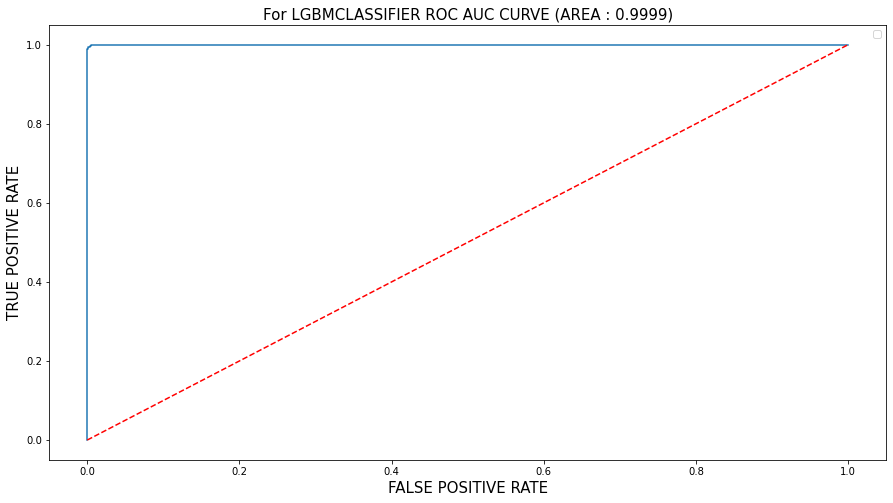

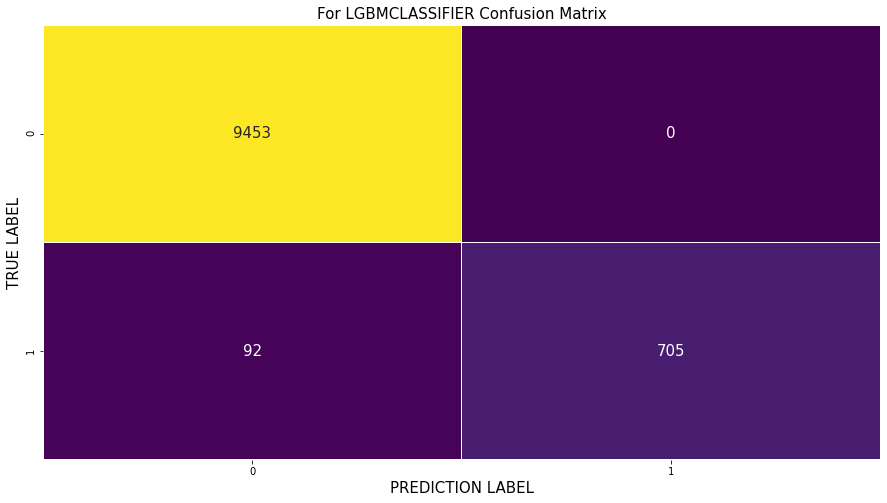

No handles with labels found to put in legend.


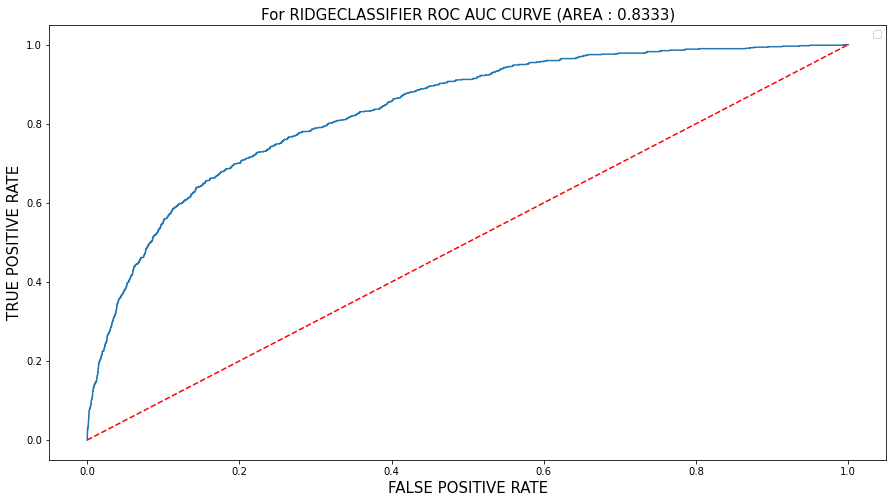

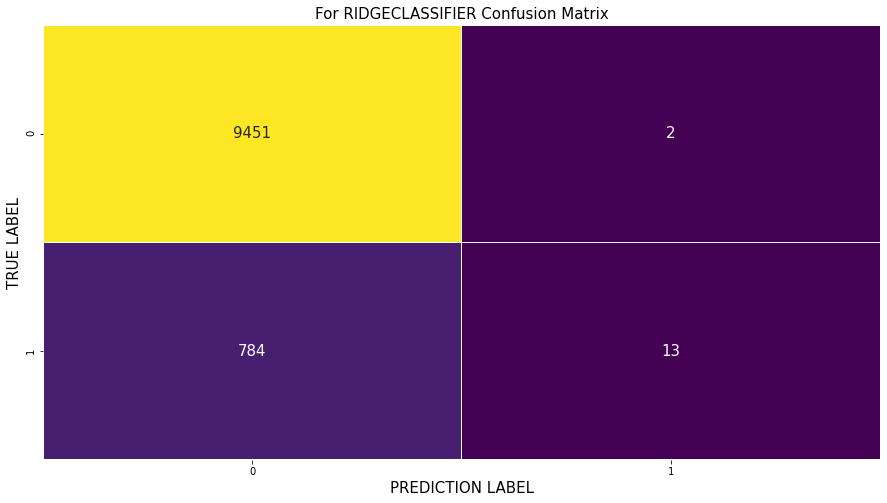

In [25]:
# Base olarak değerlendirilen model olduğu için değerler bizi yanlıtmasın cross validation etkisi yok 
# Verilerin az olduğunu belirtmek isterim.

for model in base_cv_dicts:
    base_roc_auc_graph(base_cv_dicts[model], X, y)
    confusion_matrix_graph(base_cv_dicts[model], X , y)

  0%|          | 0/636 [00:00<?, ?it/s]

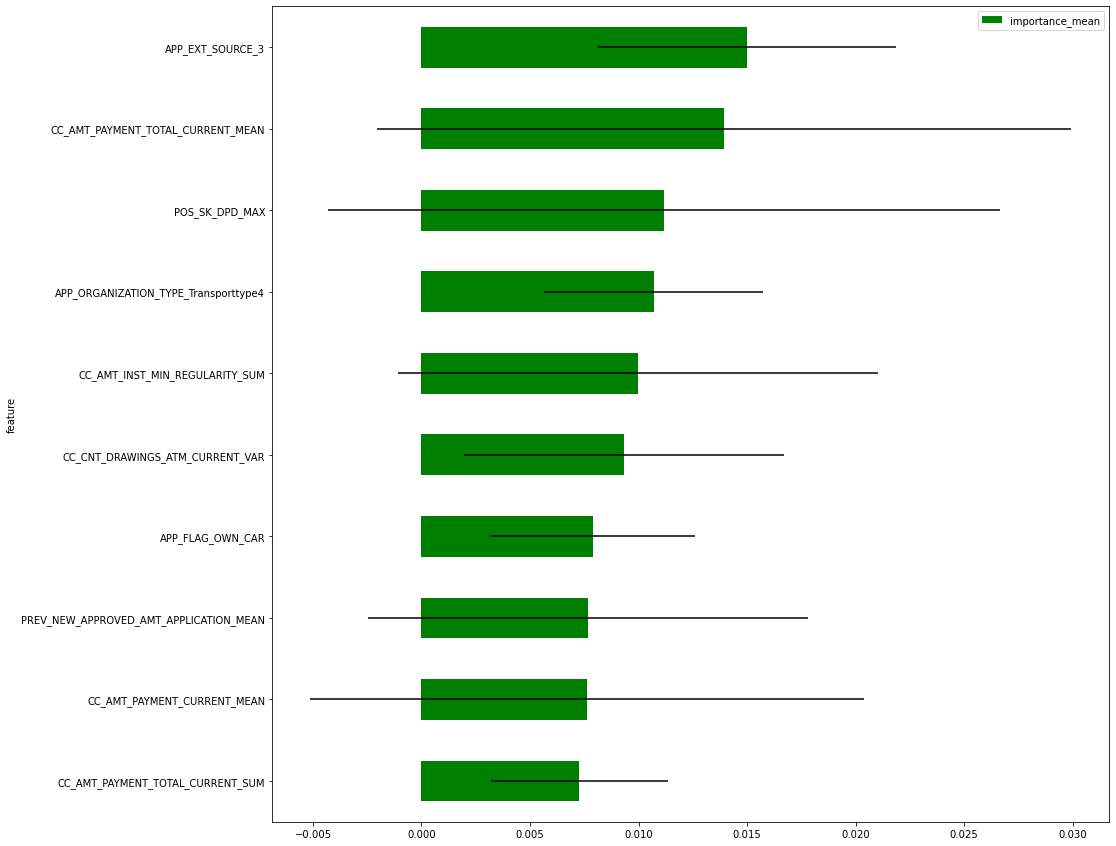

In [27]:
importance_imp = lofo_imp(dataframe = lofo_df_sampe,target = "TARGET",model = base_cv_dicts["Ridge"],
                          cv = 3, scoring_name="roc_auc",nums = 10)

In [27]:
# Zaman fazla aldığı için çalıştıramadım ..

#importance_imp = lofo_imp(dataframe = lofo_df_sample,target = "TARGET",model = base_cv_dicts["LightGBM"],
#                          cv = 3, scoring_name="roc_auc",nums = 10)

## KFOLDS METHOD

## LightGBM Model

In [28]:
# Kfold Method ....

base_lgbm_kfold_data, base_lgbm_kfold_liste = folds_models_lgbm(LGBMClassifier(), X, y , n_splits=3, kfold=True)

KFold Using....
KFold Splits = 3

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.999999	training's binary_logloss: 0.0387521	valid_1's auc: 0.752626	valid_1's binary_logloss: 0.248777
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.999999	training's binary_logloss: 0.0387521	valid_1's auc: 0.752626	valid_1's binary_logloss: 0.248777
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 1	training's binary_logloss: 0.0309994	valid_1's auc: 0.729249	valid_1's binary_logloss: 0.304267
Did not meet early stopping. Best iteration is:
[95]	training's auc: 1	training's binary_logloss: 0.0336251	valid_1's auc: 0.729961	valid_1's binary_logloss: 0.30073
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 1	training's binary_logloss: 0.0349384	valid_1's auc: 0.751511	valid_1's binary_logloss: 0.26382
Did not meet early stopping. Best iteration is:
[80]	training's auc: 1	tr

In [29]:
# StratifiedKfold Method ...

base_lgbm_stratifiedkfold_data, base_lgbm_stratifiedkfold_liste = folds_models_lgbm(LGBMClassifier(), X, y , n_splits=3, kfold=False)

StratifiedKFold Using....
StratifiedKFold Splits = 3

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 1	training's binary_logloss: 0.0351483	valid_1's auc: 0.727629	valid_1's binary_logloss: 0.278219
Did not meet early stopping. Best iteration is:
[96]	training's auc: 1	training's binary_logloss: 0.0373251	valid_1's auc: 0.726038	valid_1's binary_logloss: 0.276475
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 1	training's binary_logloss: 0.0352714	valid_1's auc: 0.750695	valid_1's binary_logloss: 0.270509
Did not meet early stopping. Best iteration is:
[97]	training's auc: 1	training's binary_logloss: 0.0370857	valid_1's auc: 0.752372	valid_1's binary_logloss: 0.268636
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 1	training's binary_logloss: 0.0371907	valid_1's auc: 0.752979	valid_1's binary_logloss: 0.263409
Did not meet early stopping. Best iteration is:
[93]	training's au

In [30]:
# Burda n_splits = 3 olarak alındı ne kadar fazla olursa o kadar net bir score elde ebebiliriz.
# Accuracy , Roc_Auc ve KFold değerlerine karşılık score olarak tabloda gözükmektedir.
# Kfold ile Stratifiedkfold göre sonuçlarına göre kfold methodu az da olsa etkili
# Tekrardan belirtmek isterim ki veri setini olduça düşük tutup daha hızlı sonuçlar aldığımı belirtmek isterim.
# Ancak böyle bir indirgeme ile sonuçlara varabildim.

base_lgbm_kfold_data

,KFold_NFOLD,KFold_ROC_AUC_SCORE,KFold_ACCURACY_SCORE
0,1.0000,0.7526,0.9248
1,2.0000,0.7300,0.9163
2,3.0000,0.7523,0.9183


In [31]:
base_lgbm_stratifiedkfold_data

,StratifiedKFold_NFOLD,StratifiedKFold_ROC_AUC_SCORE,StratifiedKFold_ACCURACY_SCORE
0,1.0000,0.7260,0.9204
1,2.0000,0.7524,0.9181
2,3.0000,0.7522,0.9201


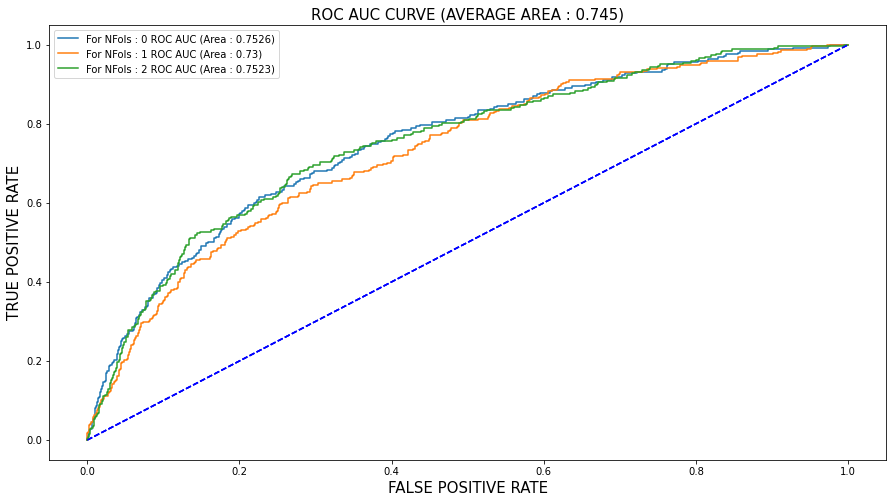

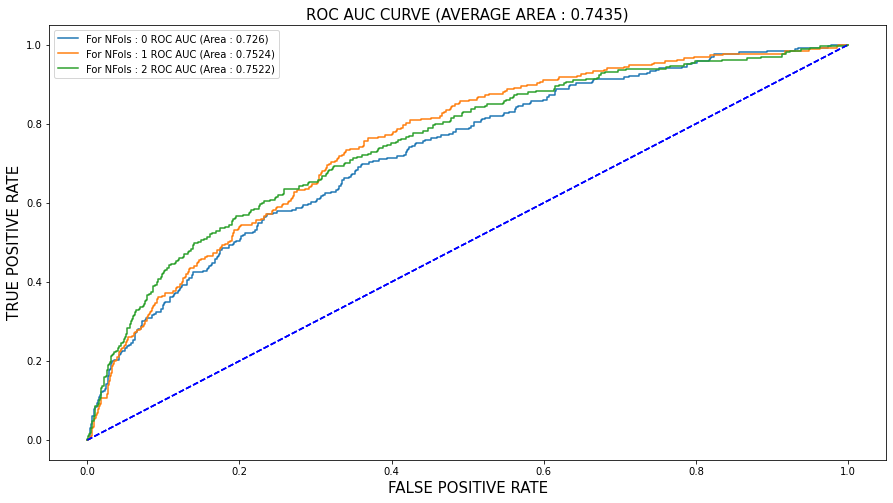

In [32]:
# Her bir kfold değerine göre roc_curve olup değerleri grafikte gösterilmiştir...
# Ortalama olarak değeri yansılıtmıştır..

roc_list = [kfold_roc_auc_graph(base_lgbm_kfold_liste), kfold_roc_auc_graph(base_lgbm_stratifiedkfold_liste)]

for roc_auc in roc_list:
    
    roc_list

## Ridge Model

In [33]:
# Kfold Method ...

base_ridge_kfold_data , base_ridge_kfold_liste = folds_models_ridge(RidgeClassifier(), X, y, n_splits=3 ,kfold=True)

KFold Using....
KFold Splits = 3



In [34]:
# StratifiedKfold Method ...

base_ridge_stratified_data , base_ridge_stratified_liste = folds_models_ridge(RidgeClassifier(), X, y, 
                                                                             n_splits=3 ,kfold=False)

StratifiedKFold Using....
StratifiedKFold Splits = 3



In [36]:
base_ridge_kfold_data

,KFold_NFOLD,KFold_ROC_AUC_SCORE,KFold_ACCURACY_SCORE
0,1.0000,0.7119,0.9271
1,2.0000,0.7178,0.9145
2,3.0000,0.7094,0.9215


In [38]:
base_ridge_stratified_data

,StratifiedKFold_NFOLD,StratifiedKFold_ROC_AUC_SCORE,StratifiedKFold_ACCURACY_SCORE
0,1.0000,0.6733,0.9195
1,2.0000,0.6993,0.9216
2,3.0000,0.7386,0.9210


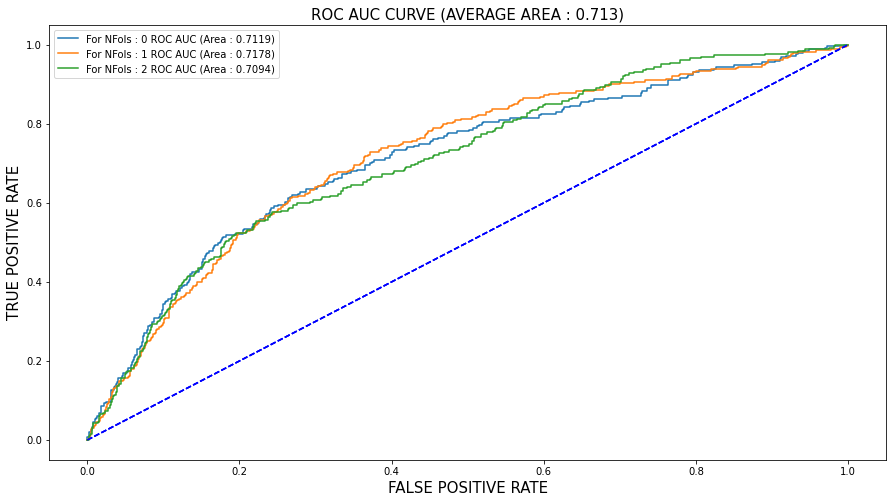

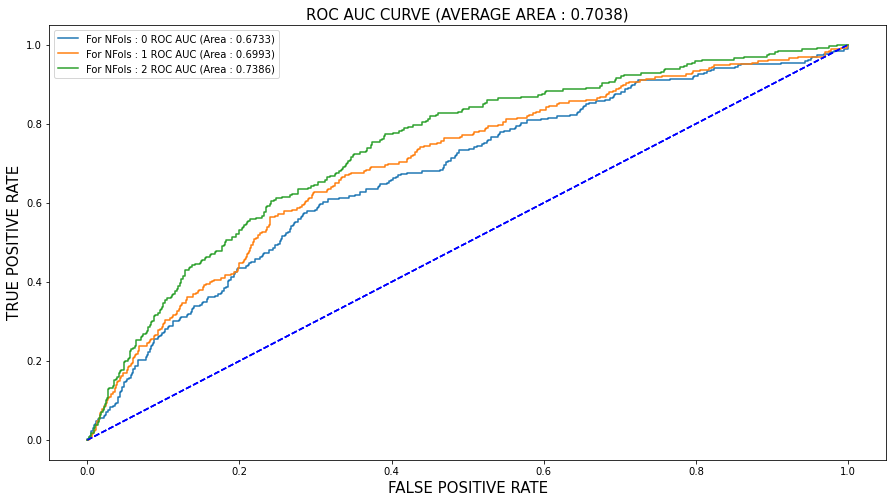

In [40]:
roc_list = [base_ridge_kfold_liste, base_ridge_stratified_liste]

for roc_auc in roc_list:
    kfold_roc_auc_graph(roc_auc)

# HyperParameter Optimization Model

In [41]:
def hyperparameters_optimization(classifiers , X, y, cv = 5):
    
    data = pd.DataFrame()
    models_dicts = {}
    index = 0
    
    for name, classifier, params in classifiers:
        
        cv_results = cross_validate(estimator = classifier,
                                    X = X,
                                    y = y,
                                    cv = cv,
                                    scoring = ["roc_auc","accuracy"],
                                    n_jobs = -1,
                                    verbose = 0)
        
        roc_score = cv_results["test_roc_auc"].mean()
        accuracy = cv_results["test_accuracy"].mean()
        
        print("".center(50,"#"),end = "\n\n")
        
        print(f"For {type(classifier).__name__.upper()} Before CV",end = "\n\n")
        print(f"Roc Auc Score : {roc_score}\nAccuracy Score : {accuracy}",end = "\n\n")
    
        
        best_grid = GridSearchCV(estimator=classifier,
                                 param_grid=params,
                                 scoring = "roc_auc", 
                                 cv=cv,
                                 n_jobs=-1,
                                 verbose=0,
                                 refit=True).fit(X,y)
        
        print(f"Best Params : {best_grid.best_params_}",end = "\n\n")
        
        final_model = classifier.set_params(**best_grid.best_params_)
        final_cv_results = cross_validate(estimator = final_model,
                                          X = X,
                                          y = y,
                                          cv = cv,
                                          scoring = ["roc_auc","accuracy"],
                                          n_jobs = -1,
                                          verbose = 0)
        
        final_roc_score = final_cv_results["test_roc_auc"].mean()
        final_accuracy = final_cv_results["test_accuracy"].mean()
        
        print(f"For {type(classifier).__name__.upper()} After CV",end = "\n\n")
        print(f"Roc Auc Score : {final_roc_score}\nAccuracy Score : {final_accuracy}",end = "\n\n")
        
        data.loc[index, "NAME"] = name
        data.loc[index, "BEFORE ROC_AUC_SCORE"] = roc_score
        data.loc[index, "BEFORE ACCURACY SCORE"] = accuracy
        data.loc[index, "AFTER ROC_AUC_SCORE"] = final_roc_score
        data.loc[index, "AFTER ACCURACY SCORE"] = final_accuracy
        index+=1
        
        models_dicts[name] = final_model
        
        del final_model,classifier,final_accuracy,final_roc_score,roc_score,accuracy
        gc.collect()
        
    data = data.sort_values(by = "AFTER ROC_AUC_SCORE", ascending = False)
    data = data.set_index("NAME")
    
    return data , models_dicts

In [42]:
def gridsearchCV(classifiers, X, y , cv = 3):
    models_dict = {}
    
    for name, classifier, params in classifiers:
            
        best_grid = GridSearchCV(estimator=classifier,
                                 param_grid= params,
                                 scoring = "roc_auc",
                                 n_jobs=-1,
                                 verbose=True,
                                 cv = cv).fit(X,y)
        
        print(f"For {name.upper()} Best Params : {best_grid.best_params_}",end = "\n\n")
        
        final_classifier = classifier.set_params(**best_grid.best_params_)
            
        models_dict[name] = final_classifier
        
    
    return  models_dict

In [43]:
def randomsizedsearchCV(classifiers , X , y ,cv = 3):
    models_dict = {}
    
    for name, classifier, params in classifiers:
        
        best_grid = RandomizedSearchCV(estimator=classifier,
                                       param_distributions=params,
                                       n_iter=1000,
                                       scoring="roc_auc",
                                       cv = cv,
                                       random_state=314,
                                       n_jobs=-1,
                                       refit=True,
                                       verbose = True).fit(X,y)
        
        print(f"For {name.upper()} Best Params : {best_grid.best_params_}", end = "\n\n")
        
        final_classifier = classifier.set_params(**best_grid.best_params_)
        
        models_dict[name] = final_classifier
        
    return models_dict

In [44]:
# Burda Lightgbm sahip olmuş olduğu kendi importance_feature modeline uygun bir script kullandım..

def importance_feature(model, X , nums=20, save = False):
    
    data = pd.DataFrame()
    data["Values"] = model.feature_importances_
    data["Features"] = [col for col in X.columns]
    data = data.sort_values(by = "Values", ascending = False)
    data = data[:nums]
    
    size = 15
    plt.figure(figsize = (15,8))
    plt.title(f"For {type(model).__name__.upper()} Feature Importances", fontsize = size)
    plt.xlabel("Values", fontsize = size)
    plt.ylabel("Features", fontsize = size)
    sns.barplot(x = data["Values"], y  = data["Features"], )
    plt.show()
    
    if save:
        plt.savefig(type(model)._name__ + "_importance.png")

In [45]:
# Burda ise coef_ kullanarak yani kat sayı değerlerinin yüksek olduğu değerleri grafiğe dökerek en büyük etkiye sahip olanı
# ön plana çıkardım.. 

def ridge_importance_feature(model, X , nums = 20 , save = False) :
    
    data = pd.DataFrame()
    values =  model.coef_[0]
    data["Values"] = values * 100
    data["Features"] = [col for col in X.columns]
    data = data.sort_values(by = "Values", ascending = False)
    data = data[:nums]
    
    size = 15
    plt.figure(figsize = (15,8))
    plt.title(f"For {type(model).__name__.upper()} Feature Importances", fontsize = size)
    plt.xlabel("Values", fontsize = size)
    plt.ylabel("Features", fontsize = size)
    sns.barplot(x = data["Values"], y  = data["Features"], )
    plt.show()
    
    if save:
        plt.savefig(type(model)._name__ + "_importance.png")

In [47]:
# Çıkan sonuçlarda etki aynı gibi gözükmekte fakat fazla bir parametre giremedim.. Parametreler eklenebilir...
# LightGBM Değerinin azda olsa bir artış gösterdiği gözüküyor..
# Ayriyetten veri setindeki azaltmada etki edebilir bu değerler için..
# CV değerini küçük tuttuğumu belirtmek isterim..
# Etkilerin fark yaratması için bütün verisetini içeriye sokabilir ve cv değerini arttırmak sonuçlarda etki yaratabilir...
# Parametre eklemekte etki yaratabilir..

final_cv_data ,final_cv_models_dicts = hyperparameters_optimization(classifiers,X,y,cv = 3)

##################################################

For LGBMCLASSIFIER Before CV

Roc Auc Score : 0.7365888404117783
Accuracy Score : 0.9207806481209236

Best Params : {'colsample_bytree': 0.5, 'n_estimators': 300}

For LGBMCLASSIFIER After CV

Roc Auc Score : 0.7402970849937608
Accuracy Score : 0.9211708539545008

##################################################

For RIDGECLASSIFIER Before CV

Roc Auc Score : 0.7166698399622043
Accuracy Score : 0.9202928051572966

Best Params : {'alpha': 1.0, 'max_iter': 500}

For RIDGECLASSIFIER After CV

Roc Auc Score : 0.7166698399622043
Accuracy Score : 0.9202928051572966



In [48]:
base_cv_data

,ROC_AUC,ACCURACY,FIT_TIME,SCORE_TIME
NAME,,,,
LightGBM,0.7366,0.9208,8.0978,0.2197
Ridge,0.7167,0.9203,3.2557,0.0611


In [49]:
final_cv_data

,BEFORE ROC_AUC_SCORE,BEFORE ACCURACY SCORE,AFTER ROC_AUC_SCORE,AFTER ACCURACY SCORE
NAME,,,,
LightGBM,0.7366,0.9208,0.7403,0.9212
Ridge,0.7167,0.9203,0.7167,0.9203


In [50]:
for name in final_cv_models_dicts:
    final_cv_models_dicts[name].fit(X,y)
    names = name.upper() + "_After_CV_Model.pkl"
    pd.to_pickle(final_cv_models_dicts[name], open(f"C:/Users/USER/Home_Credict/MODELS/{names}","wb"))

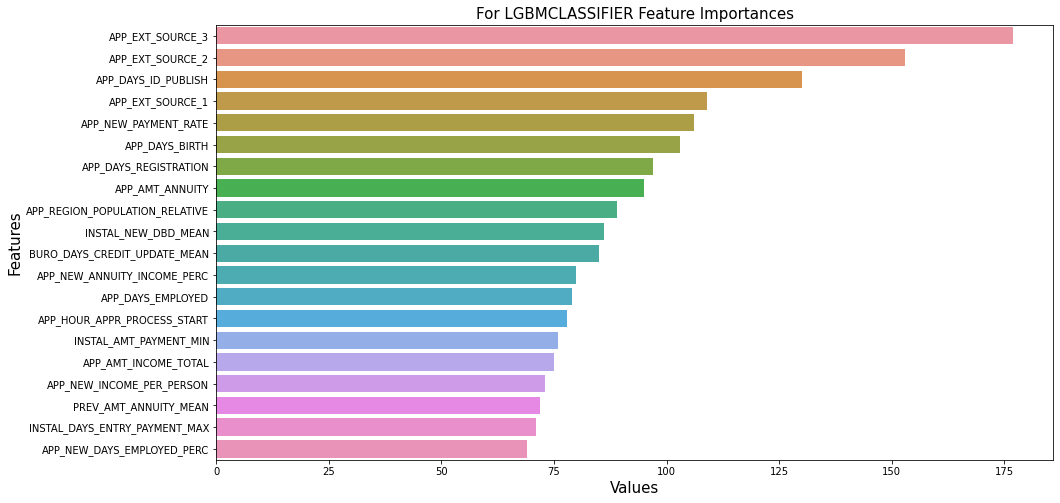

In [55]:
# APP ve APP_NEW ile başlayan değerlerin yukarlarda olduğunu görüyoruz yeni türetilen değerlerden !!!

importance_feature(final_cv_models_dicts["LightGBM"],X,nums = 20)

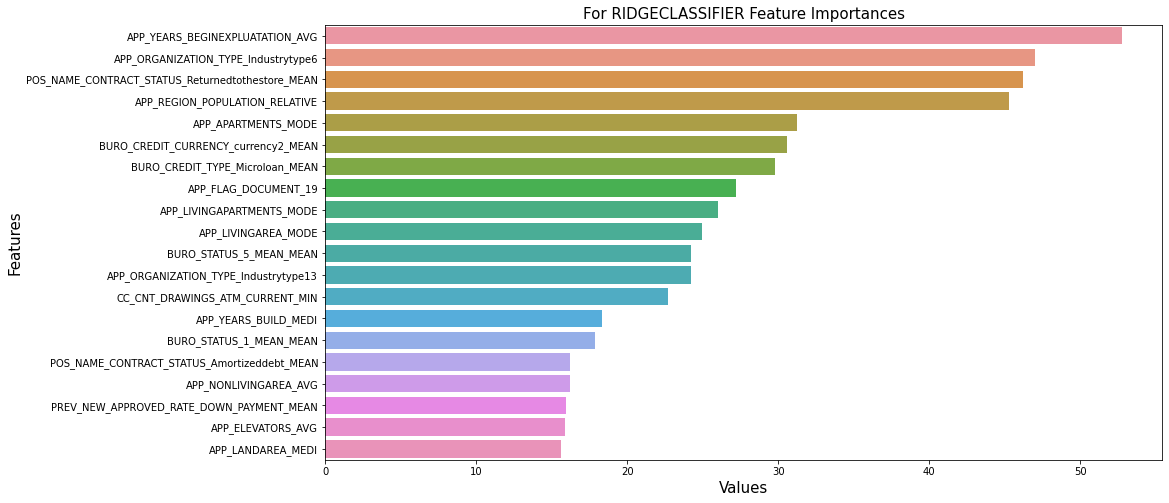

In [56]:
ridge_importance_feature(final_cv_models_dicts["Ridge"],X,nums = 20)

  0%|          | 0/636 [00:00<?, ?it/s]

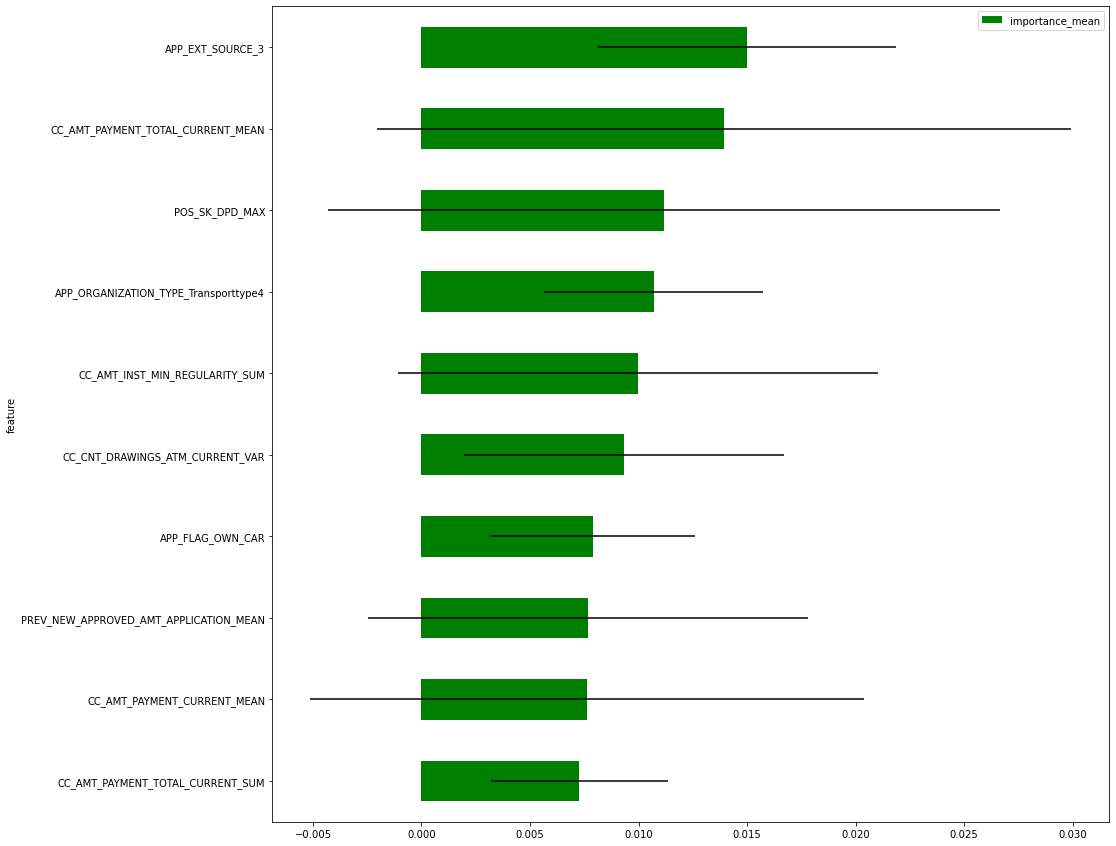

In [54]:
importance_imp_final_ridge = lofo_imp(dataframe = lofo_df_sampe,target = "TARGET",model = final_cv_models_dicts["Ridge"],
                                      cv = 3, scoring_name="roc_auc",nums = 10)

  0%|          | 0/636 [00:00<?, ?it/s]

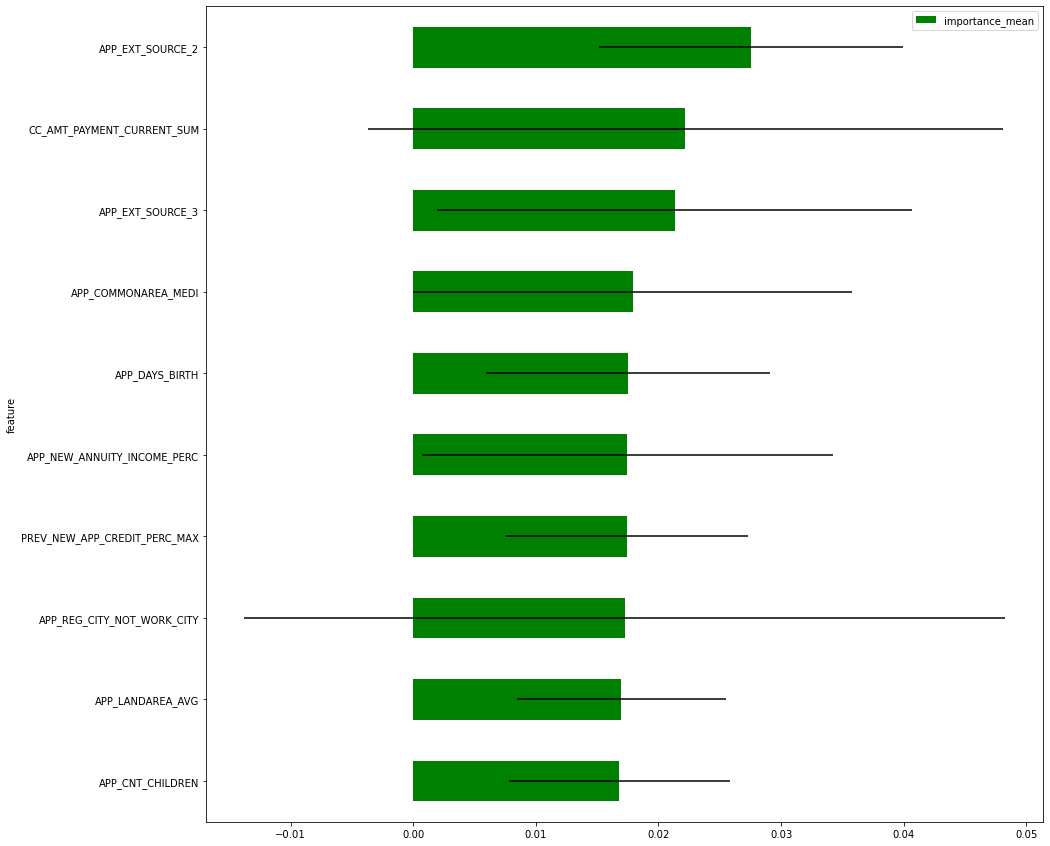

In [82]:
importance_imp_final_lgbm = lofo_imp(dataframe = lofo_df_sampe,target = "TARGET",model = final_cv_models_dicts["LightGBM"],
                                     cv = 3, scoring_name="roc_auc",nums = 10)

No handles with labels found to put in legend.


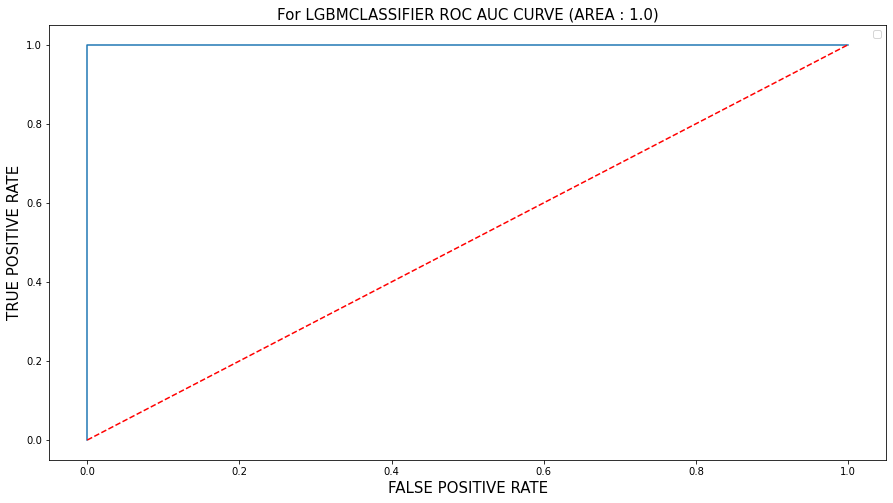

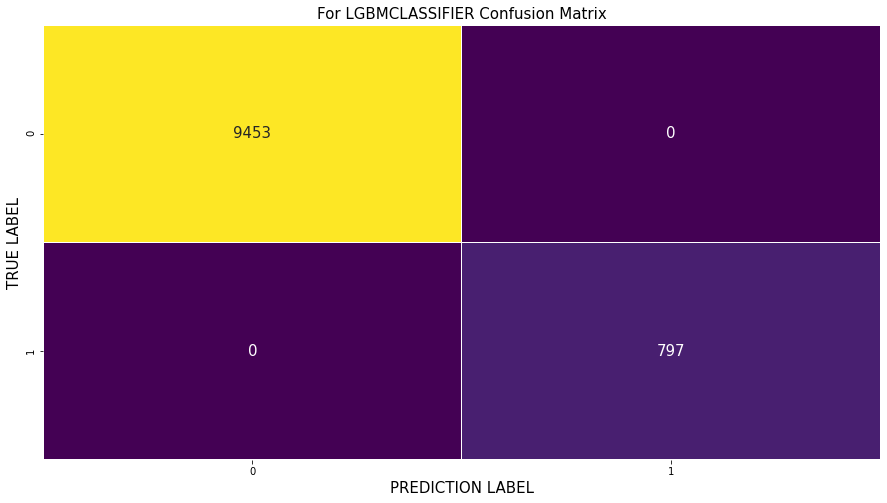

No handles with labels found to put in legend.


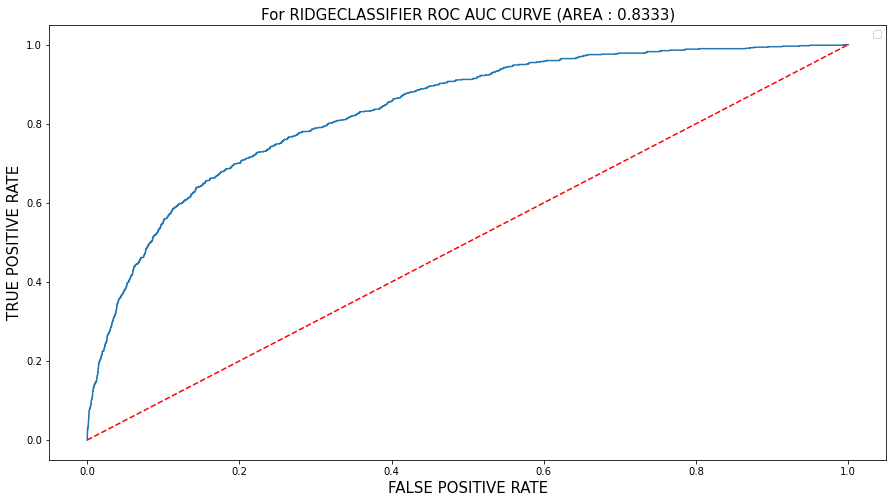

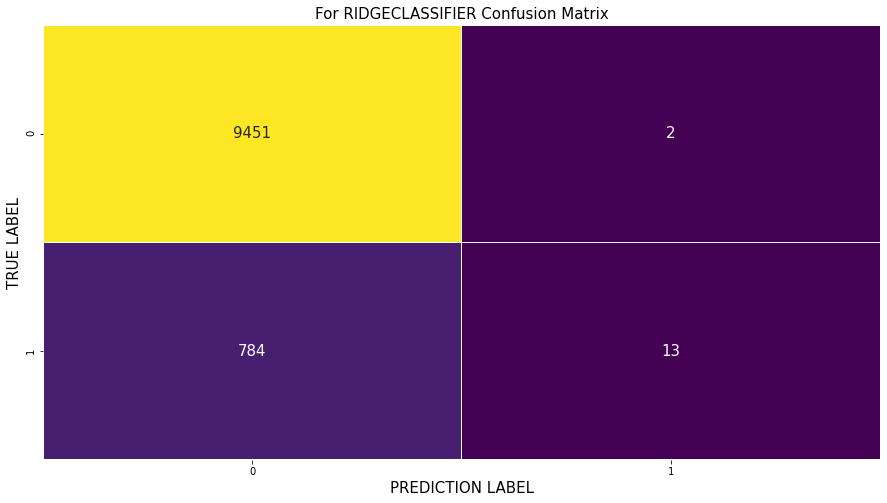

In [57]:
# Burda önceki değerler ile karşılaştırdığımızda bir etki sağlamış olduğu görmüş oluyoruz.
# Her ne kadar bu sonuçlara güvenmek doğru olmadığı gibi parametrelerin bir artı sağlamış olduğu görünmektedir..
# Ridge değerlerinde bir değişiklik yok çünkü parametreler bir etki yaratmadı farkı parametreler ile bu değerler değişebilir..
# Ama burda gözle görülür olarak lgbmclassifier üzerinden değişiklik olduğu gibi test değerleri için predict yapabiliriz..

for name in final_cv_models_dicts:
    
    base_roc_auc_graph(final_cv_models_dicts[name],X,y)
    confusion_matrix_graph(final_cv_models_dicts[name],X,y)

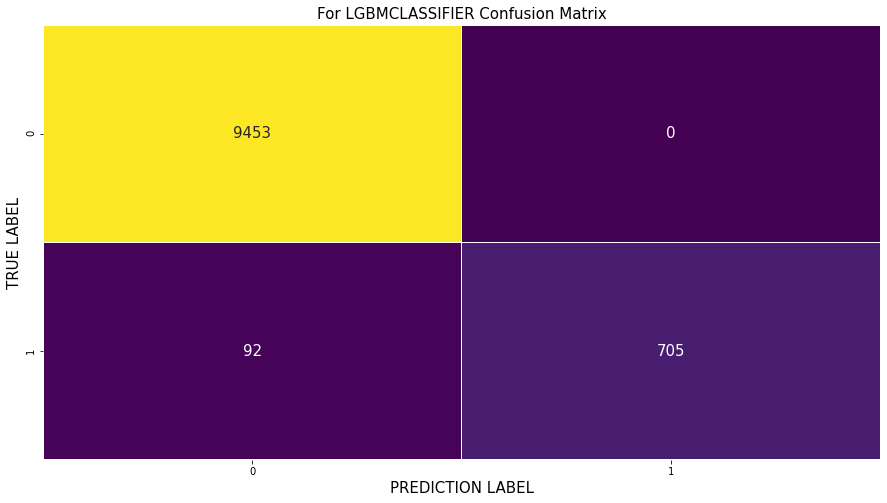

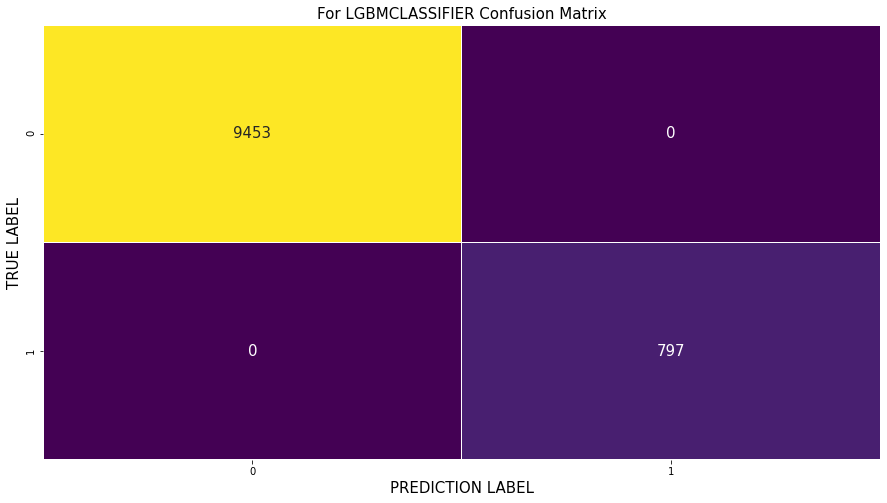

In [58]:
# Base Model ile GridSearch sonraki değerlerde değişiklikleri gözlemleyebiliyoruz...
# Tekrar hatırlatmak isterim bu sonuçlara güven yoktur değişimleri gözlemlemek için farklarına baktık
# Güven olmamasının sebebi Veri setini az tuttuk ve Parametre olarak az değerler ile gözlemledik
# Bilgisayar performansının yettiği kadarı !!!

confusion_matrix_graph(LGBMClassifier().fit(X,y),X,y)
confusion_matrix_graph(final_cv_models_dicts["LightGBM"],X,y)

## Another Grid Searh Method ...

In [59]:
# Tek kullanım GridSearchCV Methodu...

final_ridge = gridsearchCV(classifiers_ridge,X, y , cv = 3)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
For RIDGE Best Params : {'alpha': 1.0, 'max_iter': 500}



In [60]:
# Tek kullanumlık RandomizedSearchCV Methodu...

final_lgbm = randomsizedsearchCV(classifiers_lgbm, X, y, cv = 3)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
For LIGHTGBM Best Params : {'n_estimators': 300, 'colsample_bytree': 0.5}



In [61]:
final_lgbm

{'LightGBM': LGBMClassifier(colsample_bytree=0.5, n_estimators=300)}

In [62]:
final_ridge

{'Ridge': RidgeClassifier(max_iter=500)}

# Analyzing Model Complexity with Learning Curves

In [64]:
def val_curve_params(estimator , X , y , param_name, param_range , scoring , cv =5 ):
    
    train_scores , test_scores = validation_curve(estimator = estimator,
                                                  X = X,
                                                  y = y,
                                                  param_name = param_name ,
                                                  param_range = param_range,
                                                  n_jobs = -1,
                                                  verbose = 0,
                                                  scoring = scoring)
    
    mean_train_scores = np.mean(train_scores, axis = 1)
    mean_test_scores = np.mean(test_scores,axis = 1)
    
    plt.figure(figsize = (15,8)) 
    
    plt.plot(param_range, mean_train_scores , label = "TRAINING SCORES" , color = "g")
    plt.plot(param_range, mean_test_scores , label = "VALIDATION SCORES", color = "r")
    
    plt.title(f"Validation Curve For {type(estimator).__name__.upper()}")
    plt.xlabel(f"Number Of {param_range} : {param_name}")
    plt.ylabel(f"{scoring}")
    plt.legend(loc = "best")
    plt.show()

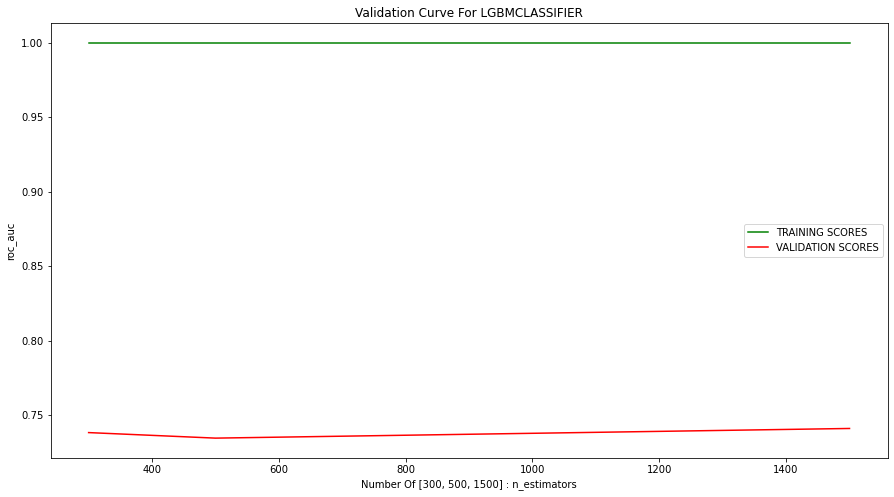

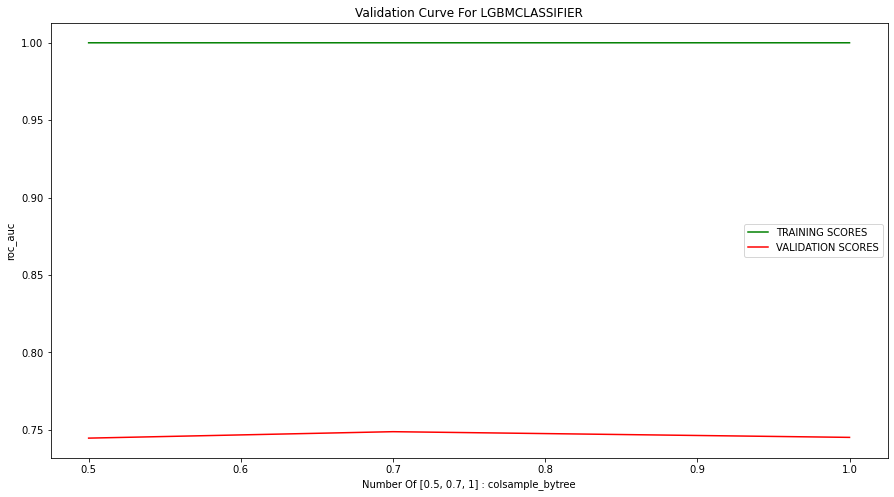

In [65]:
# Burdaki amaç gridsearch yada randomsizedsearch methodlarının doğruluğunu test edebiliriz..
# Yani Burda parametreleri  modelin öğrenme yada kendini ezberlemeye çalıştığı noktadan önce parametreleri belirleyebiliriz..
# Unutmayalım ki burda ki sonuçlar eşlenik değil yani parametreler burda tek tek değerlendiriliyor..
# Birden çok parametreye bağlı bir sonuç çıkmıyor..
# Seçilen parametrelere göre değerlendirme yapabiliriz..


for i in lightgbm_params:
    
    val_curve_params(estimator = LGBMClassifier(), 
                     X = X, 
                     y = y, 
                     param_name = i,
                     param_range = lightgbm_params[i],
                     scoring="roc_auc",
                     cv = 3)

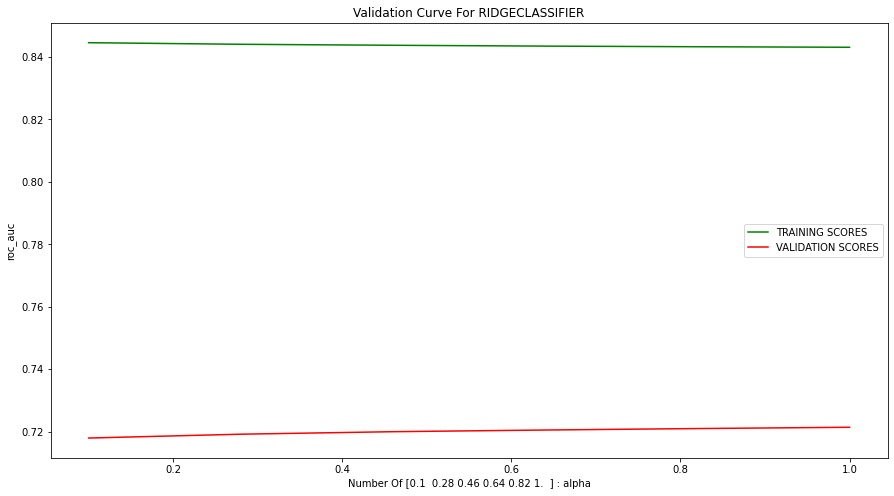

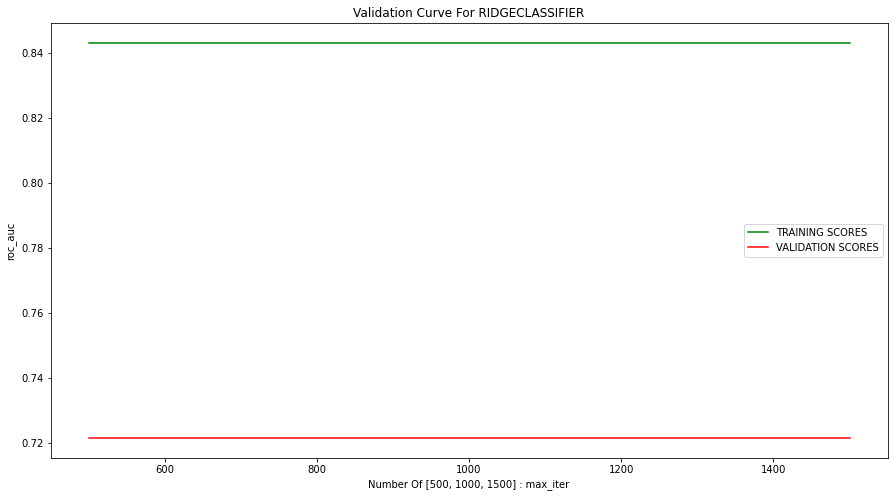

In [67]:
for  i in ridge_params:
    
    val_curve_params(estimator = RidgeClassifier(),
                     X = X,
                     y = y,
                     param_name = i,
                     param_range = ridge_params[i],
                     scoring = "roc_auc",
                     cv = 3)

## Test Predictions

In [68]:
submission_df = pd.DataFrame()

In [69]:
df_path = "C://Users//USER//Home_Credict/PKL/last_dataframe.pkl"
#reduced_df_path = "C://Users//USER//Home_Credict/PKL/reduced_dataframe.pkl"
df = pickle.load(open(df_path,"rb"))

In [70]:
test = df[df["TARGET"].isnull()]
submission_df["SK_ID_CURR"] = test["SK_ID_CURR"]

In [71]:
y_pred = final_cv_models_dicts["LightGBM"].predict(test.drop(["SK_ID_CURR","TARGET","APP_index"], axis = 1))
submission_df["TARGET"] = y_pred

In [72]:
submission_df.head()

,SK_ID_CURR,TARGET
307511,100001,0.0000
307512,100005,0.0000
307513,100013,0.0000
307514,100028,0.0000
307515,100038,0.0000


In [73]:
submission_df.to_csv("submission_df.csv",index = False)